# Yhteys databaseen ja tarvittavat riippuvuudet

In [37]:
# Run this code if you get errors with missing requirements
import sys
!{sys.executable} -m pip install mysql-connector

import pandas as pd
import mysql.connector

mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)



# Noukitaan databasesta halutut tiedot sql-kyselyllä

In [60]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, x, y, COUNT(node_id), timestamp FROM SensorData WHERE timestamp > '2019-06-01 13:05:08.078133+00:00' AND timestamp < '2019-06-20 13:05:08.078133+00:00' GROUP BY node_id ");
database = pd.DataFrame(mycursor.fetchall())
print(database)

#COUNT ja GROUP BY jo hakuvaiheessa



    node_id      x     y  COUNT(node_id)                            timestamp
0      3200    135  2464          287102  b'2019-06-01 13:05:08.987486+00:00'
1      3224   3852  3354          780661  b'2019-06-01 13:05:08.991554+00:00'
2      3240    100   591          609000  b'2019-06-01 14:11:23.994686+00:00'
3     42787    169  2598               1  b'2019-06-13 06:15:23.987745+00:00'
4     51719    492  2004          654583  b'2019-06-01 13:33:46.994769+00:00'
5     51735    950  3750           75999  b'2019-06-03 05:36:30.994673+00:00'
6     51751    184  2507          793097  b'2019-06-02 11:32:32.986908+00:00'
7     51850    314  1361          588988  b'2019-06-01 13:05:56.994484+00:00'
8     51866    950  3650          333174    b'2019-06-02 11:32:31.9869+00:00'
9     51889    112  2441          417422   b'2019-06-01 13:05:08.98749+00:00'
10    51968    251  1133          244531  b'2019-06-01 13:05:14.994556+00:00'
11    51976   9533  2072           20951  b'2019-06-01 13:05:08.

# Rajataan aluetta (latausasemat yms)

In [61]:
# talon rajoja
database = database[database.y > -1]
database = database[database.y < 10407]
database = database[database.x < 10100]
database = database[database.x > 240]

# Latausasemat pois
database = database.drop(database[(database.x < 1850.0) & (database.y > 3000)].index)
# Oikea ylänurkka pois
database = database.drop(database[(database.x > 8200) & (database.y < 250)].index)
# tuloaula - ei vissiin toimi tracking siellä hyvin
database = database.drop(database[(database.x < 1000) & (database.y > 2500)].index)
print(database)

    node_id     x     y  COUNT(node_id)                            timestamp
1      3224  3852  3354          780661  b'2019-06-01 13:05:08.991554+00:00'
4     51719   492  2004          654583  b'2019-06-01 13:33:46.994769+00:00'
7     51850   314  1361          588988  b'2019-06-01 13:05:56.994484+00:00'
10    51968   251  1133          244531  b'2019-06-01 13:05:14.994556+00:00'
11    51976  9533  2072           20951  b'2019-06-01 13:05:08.987581+00:00'
18    53011   242  1101          151882  b'2019-06-03 05:16:51.995237+00:00'
25    53936   251  2399          621294  b'2019-06-02 11:32:31.986985+00:00'
26    54016  8441  2080          752629  b'2019-06-01 13:05:08.994558+00:00'


# Laitetaan timestamppi dataframeen ja poistetaan siitä turhat, lisätään kesä- ja talviajan huomionti (timezone)

In [62]:
database['timestamp'] = database['timestamp'].astype('str')
database['timestamp'] = database['timestamp'].str.rstrip("'+00:00'")
database['timestamp'] = database['timestamp'].str.lstrip("b'")
database['timestamp'] = database['timestamp'].astype('datetime64[s]')

database.timestamp = database.timestamp.dt.tz_localize('UTC')
database.timestamp = database.timestamp.dt.tz_convert('Europe/Helsinki')

database = database.sort_values(by='timestamp',ascending=True)

nodet = pd.DataFrame()

nodet['timestamp'] = database['timestamp']



print(nodet)


                   timestamp
1  2019-06-01 16:05:08+03:00
11 2019-06-01 16:05:08+03:00
26 2019-06-01 16:05:08+03:00
10 2019-06-01 16:05:14+03:00
7  2019-06-01 16:05:56+03:00
4  2019-06-01 16:33:46+03:00
25 2019-06-02 14:32:31+03:00
18 2019-06-03 08:16:51+03:00


# Muutetaan timestamp datetime64 muotoon ja pyörristetään tunnin tarkkuudelle
### Pudotetaan aukiolon ulkopuolella olevat ajat

In [63]:
nodet['timestamp'] = nodet['timestamp'].astype('datetime64[ns]')
nodet['timestamp'] = pd.Series(nodet['timestamp']).dt.round("H")

nodet = nodet.drop(nodet[(nodet.timestamp.dt.hour > 21)].index)
nodet = nodet.drop(nodet[(nodet.timestamp.dt.hour < 8)].index)



print(nodet)

             timestamp
1  2019-06-01 13:00:00
11 2019-06-01 13:00:00
26 2019-06-01 13:00:00
10 2019-06-01 13:00:00
7  2019-06-01 13:00:00
4  2019-06-01 14:00:00
25 2019-06-02 12:00:00


# laitetaan node_id count ja prosenttiosuus kärreistä

In [64]:

nodet['node_id'] = database['node_id']
nodet['count'] = database['COUNT(node_id)']
nodet['prosenttiosuus'] = 100 * (database['COUNT(node_id)'] / (database['COUNT(node_id)'].sum()))

print(nodet)

             timestamp  node_id   count  prosenttiosuus
1  2019-06-01 13:00:00     3224  780661       20.460152
11 2019-06-01 13:00:00    51976   20951        0.549100
26 2019-06-01 13:00:00    54016  752629       19.725469
10 2019-06-01 13:00:00    51968  244531        6.408853
7  2019-06-01 13:00:00    51850  588988       15.436642
4  2019-06-01 14:00:00    51719  654583       17.155805
25 2019-06-02 12:00:00    53936  621294       16.283342


# Plotataan node_id ja prosenttiosuus
### Saadaan siis kärryjen prosenttiosuus koko ajalta

Text(0.5, 0, 'Kärryn numero')

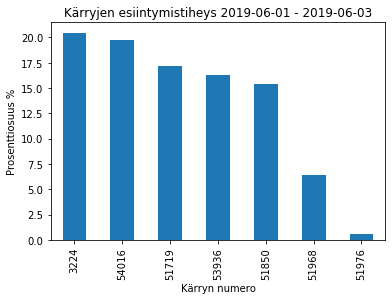

In [65]:
import pylab as plt

nodet.groupby("node_id").prosenttiosuus.mean().sort_values(ascending=False)[:23].plot.bar(title='Kärryjen esiintymistiheys ' + str(database.timestamp.dt.date.iloc[0]) + " - " + str(database.timestamp.dt.date.iloc[-1]))
plt.ylabel('Prosenttiosuus %')
plt.xlabel('Kärryn numero')